In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfield
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), 
                                            std=(3*0.2023, 3*0.1994, 3*0.2010))])

cifar_dset_train = torchvision.datasets.CIFAR10('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

cifar_dset_test = torchvision.datasets.CIFAR10('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
activation = hard_sigmoid
# architecture = [int(32*32*3), 500, 10]
architecture = [int(32*32*3), 1000, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff': np.array([0.08, 0.04])/10, 'fb': np.array([ 0.0, 0.04])/10}

neural_lr_start = 0.1
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 2
neural_dynamic_iterations_free = 5
hopfield_g = 0.1
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfield(architecture = architecture, lambda_ = lambda_, 
                                      epsilon = epsilon, activation = activation)

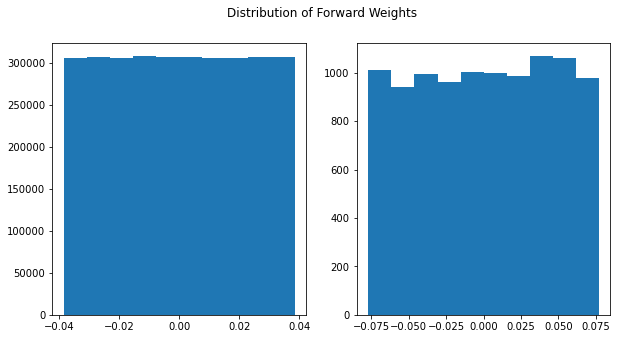

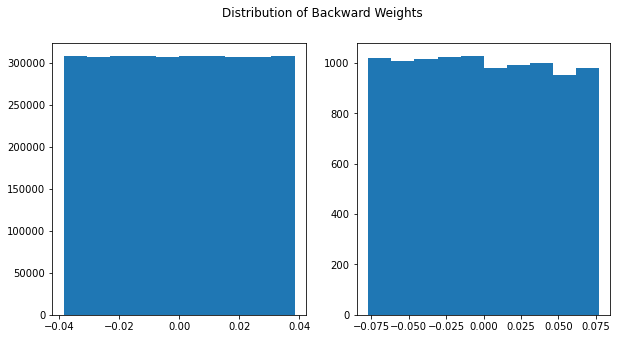

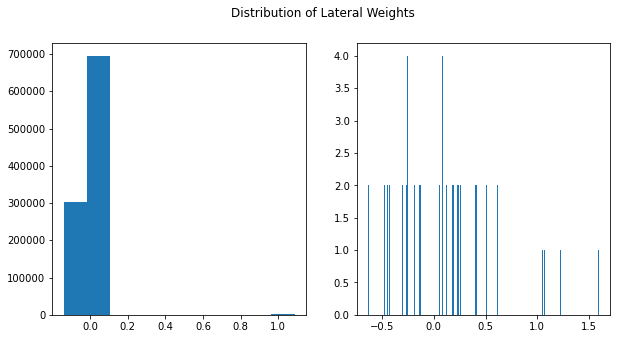

In [5]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.Wff[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wff[1]['weight']).reshape(-1,1))
plt.suptitle("Distribution of Forward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.Wfb[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wfb[1]['weight']).reshape(-1,1))
plt.suptitle("Distribution of Backward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.B[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.B[1]['weight']).reshape(-1,1),bins = 500)
plt.suptitle("Distribution of Lateral Weights")
plt.show()

In [6]:
_ = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g,
                                          neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                          neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.11884


In [7]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 10

for epoch_ in range(n_epochs):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (0.95)**epoch_, 'fb' : lr_start['fb'] * (0.95)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfield(model, train_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfield(model, test_loader, hopfield_g, neural_lr_start, 
                                                    neural_lr_stop, neural_lr_rule, 
                                                    neural_lr_decay_multiplier, 
                                                    neural_dynamic_iterations_free, 
                                                    device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

2500it [01:15, 32.94it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.193, Test Accuracy : 0.1974


2500it [01:10, 35.52it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.2229, Test Accuracy : 0.224


2500it [01:09, 36.08it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.25118, Test Accuracy : 0.2527


2500it [01:16, 32.84it/s]
0it [00:00, ?it/s]

Epoch : 4, Train Accuracy : 0.28584, Test Accuracy : 0.287


2500it [00:56, 44.49it/s]
0it [00:00, ?it/s]

Epoch : 5, Train Accuracy : 0.30582, Test Accuracy : 0.3102


2500it [01:16, 32.73it/s]
0it [00:00, ?it/s]

Epoch : 6, Train Accuracy : 0.32174, Test Accuracy : 0.326


2500it [01:05, 38.13it/s]
0it [00:00, ?it/s]

Epoch : 7, Train Accuracy : 0.33052, Test Accuracy : 0.3367


2500it [01:14, 33.46it/s]
0it [00:00, ?it/s]

Epoch : 8, Train Accuracy : 0.34028, Test Accuracy : 0.3439


2500it [01:15, 33.16it/s]
0it [00:00, ?it/s]

Epoch : 9, Train Accuracy : 0.34762, Test Accuracy : 0.3548


2500it [01:03, 39.40it/s]


Epoch : 10, Train Accuracy : 0.35404, Test Accuracy : 0.3581


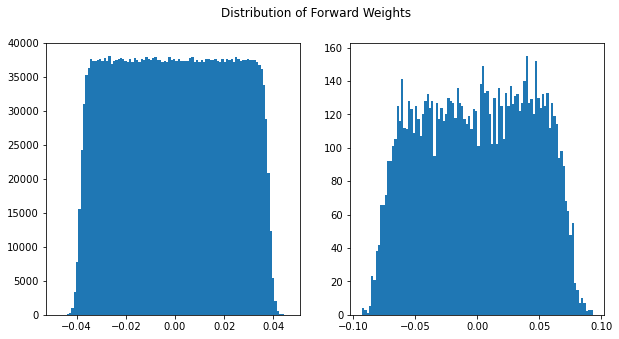

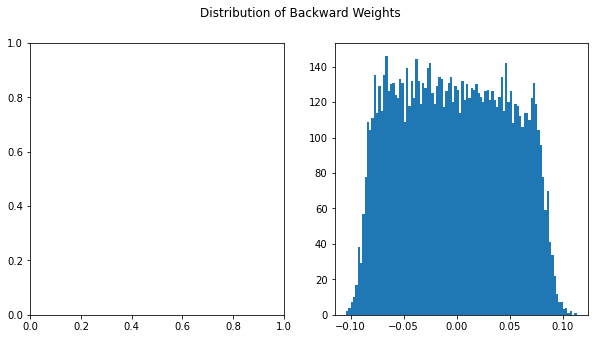

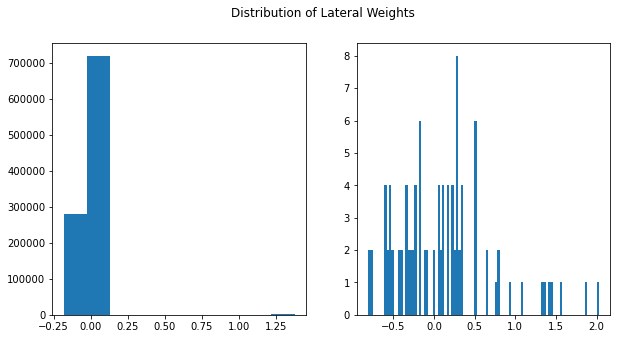

In [8]:
plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.Wff[0]['weight']).reshape(-1,1),bins = 100)
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wff[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Forward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
# plt.hist(torch2numpy(model.Wfb[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.Wfb[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Backward Weights")
plt.show()

plt.figure(figsize = (10, 5))
plt.subplot(1,2, 1)
plt.hist(torch2numpy(model.B[0]['weight']).reshape(-1,1))
plt.subplot(1,2, 2)
plt.hist(torch2numpy(model.B[1]['weight']).reshape(-1,1),bins = 100)
plt.suptitle("Distribution of Lateral Weights")
plt.show()

In [9]:
def ZeroOneNormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

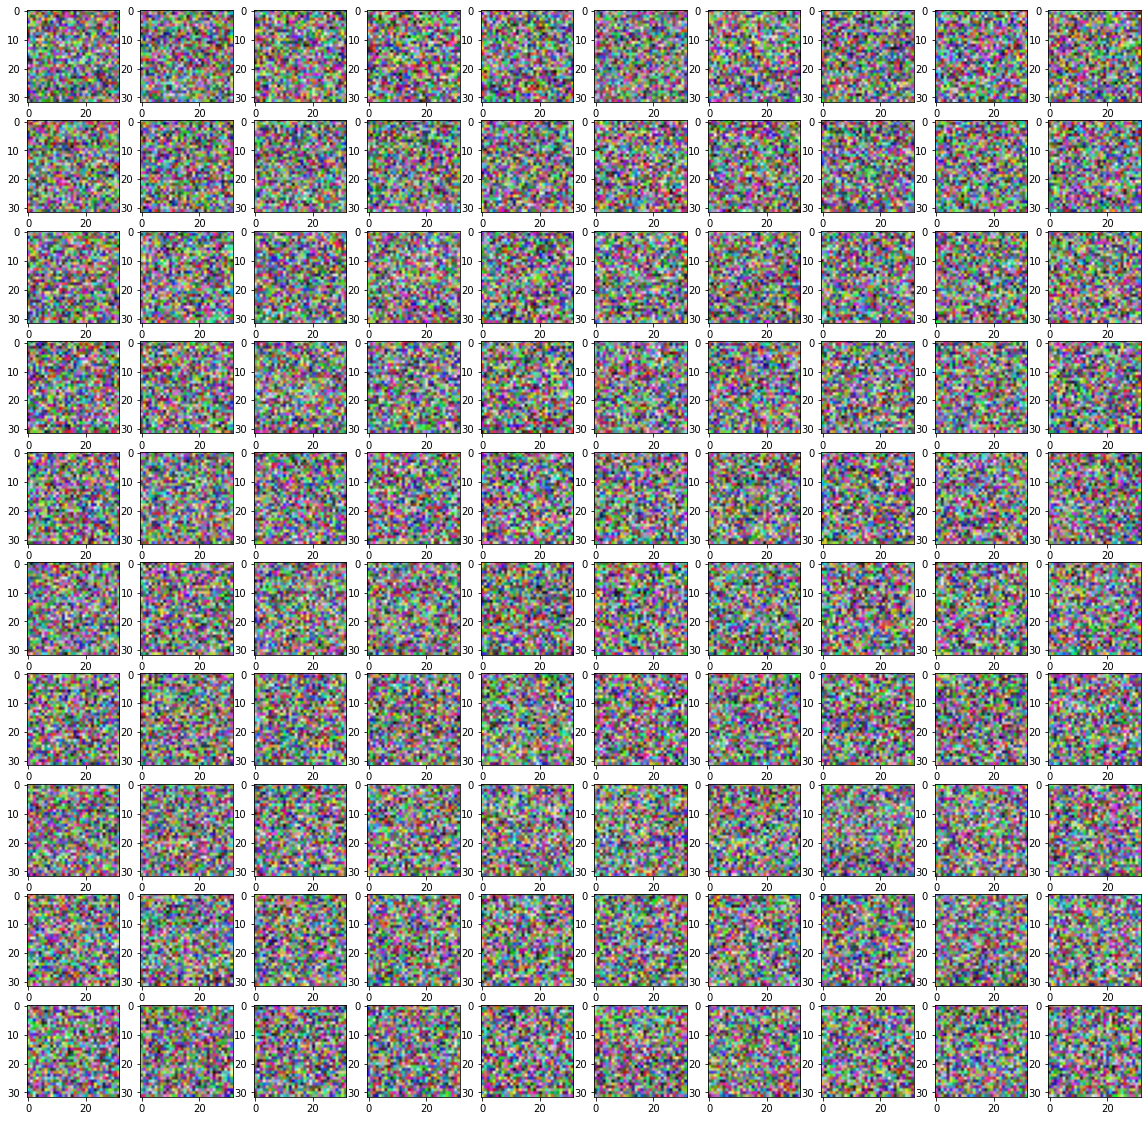

In [10]:
indices = np.random.choice(500, 100, replace = False)
plt.figure(figsize = (20,20))
for plt_idx, idx in enumerate(indices):
    plt.subplot(10, 10, plt_idx + 1)
    plt.imshow(ZeroOneNormalizeData(torch2numpy(model.Wff[0]['weight'])[idx,:]).reshape(32, 32, 3), cmap = "gray")

In [11]:
hidden_layer_list = []
ground_truth_list = []
for x, y in test_loader:
    x = x.view(x.size(0),-1).to(device).T
    y = y.to(device)

    neurons = model.init_neurons(x.size(1), device = model.device)

    # dynamics for T time steps
    neurons, _, _ = model.run_neural_dynamics_hopfield(x, 0, neurons, 
                                                       hopfield_g, 
                                                       neural_lr_start, 
                                                       neural_lr_stop, 
                                                       neural_lr_rule, 
                                                       neural_lr_decay_multiplier, 
                                                       neural_dynamic_iterations_free,
                                                       beta = 0) 
    hidden_layer_list.append(neurons[0])
    ground_truth_list.append(y)
    
hidden_layer_list = torch.concat(hidden_layer_list, axis = 1)
ground_truth_list = torch.concat(ground_truth_list)

In [12]:
from sklearn.manifold import TSNE

In [13]:
tsne_result = TSNE(n_components=2).fit_transform(torch2numpy(hidden_layer_list).T)

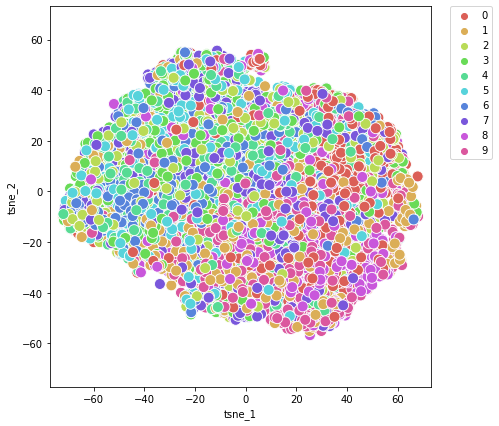

In [14]:
import seaborn as sns
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': torch2numpy(ground_truth_list)})
fig, ax = plt.subplots(1, figsize = (7,7))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, palette=sns.color_palette("hls", 10), ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

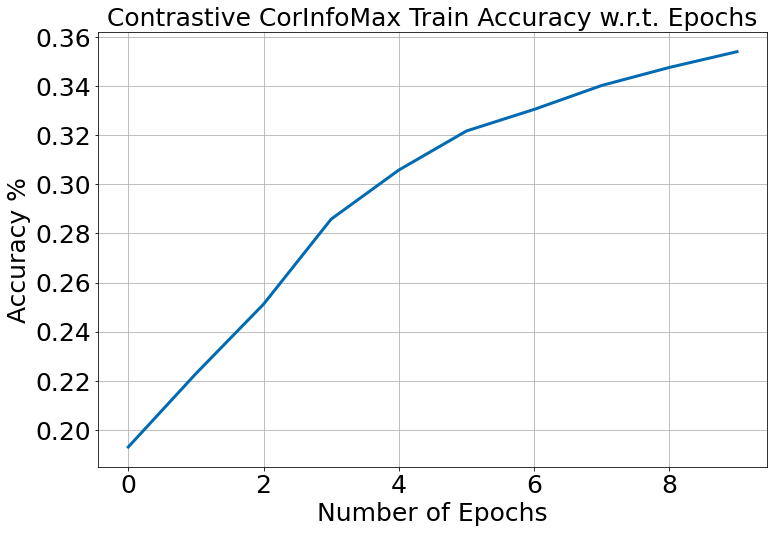

In [15]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

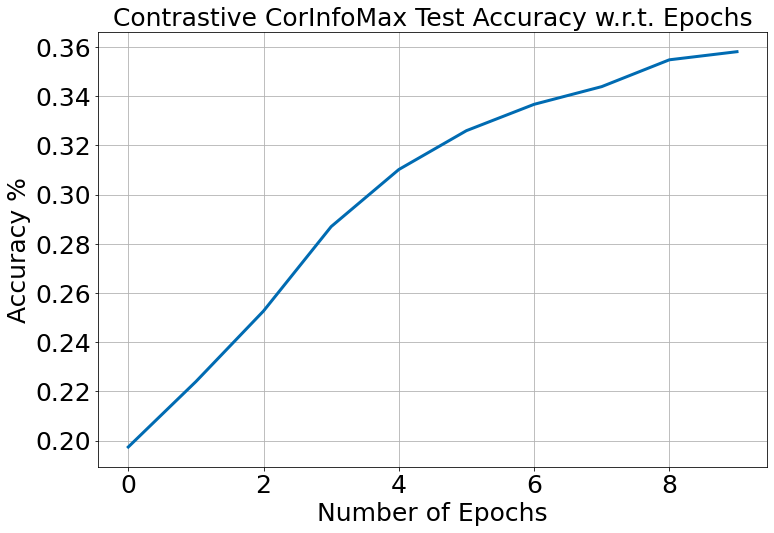

In [16]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)